In [1]:
%load_ext watermark

In [2]:
%watermark -nt

Wed Mar 18 2020 17:07:40


In [3]:
%matplotlib inline
from osgeo import gdal, ogr
import rasterio.features
import numpy as np
import matplotlib.pyplot as plt
import fiona

In [4]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
tf.debugging.set_log_device_placement(True)

# CNN Tutorial
Welcome to the CNN tutorial complement to our paper "Using context to uncover ecological patterns with CNNs".  Please be sure to check the manuscript and especially to read the Supplementary Information (SI) prior to going through this tutorial - the SI outlines all steps that will be implemented here.

## 0. Preempting common package issues

Some users occasionally have difficulties with a few of the required packages.  Here are a few tips that may come in handy:</br>

### gdal problems
Some users occasionally have issues getting gdal to work with jupyer notebooks.  If you're getting exceptions thrown during this tutorial with regards to projection issues, you can set the ignore_projections flag below to True - this is not a longterm solution, but if you're just trying to get through this notebook, it'll do.

In [7]:
ignore_projections=True

### tensorflow issues on some mac versions

Some mac users report some issues with libiomp5 (e.g. this thread https://github.com/dmlc/xgboost/issues/1715) - an easy workaround seems to be the following line:





In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 1. Training Data Preparation
The first, and likely the most time consuming, portion of building a CNN is actually assembling the requisite training data.  The goal of this code is to make that process as simple and flexible as possible.  The preparation for semantic segmentation and object detection can differ slightly, and we'll show examples for both below - but if you have the time to generate the polygons for semantic segmentation, these can easily be converted to bounding boxes for objet detection.  The reverse is harder.

### Data Prep - Checking the Inputs
We started out by examining a very small section of termite mound data.  This is our sample area:

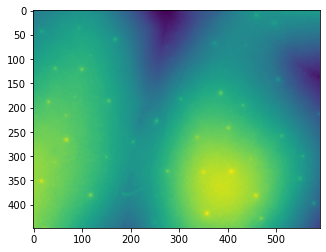

In [9]:
feature_set = gdal.Open('data/landscape7_dem_subset.tif',gdal.GA_ReadOnly)
feature = feature_set.ReadAsArray()
feature[feature == feature_set.GetRasterBand(1).GetNoDataValue()] = np.nan

plt.imshow(feature)

Cool, that's a workable area, and we can clearly see the termite mounds (the small circles) sprinkled throughout the landscape.  This looks like a great application for CNNs, given that image context is definitely necessary to ID those mounds.  The next step is to build our training data.  First things first, per __Step 1__ in the SI, we selected a region of interest, whithin which we need to ID each mound.  This was done in QGIS , by creating a new vector polygon layer (make sure to match the CRS projection to that of your feature raster), making the vector layer editable, and drawing the region of interest (ROI) - other GIS software can do the same.

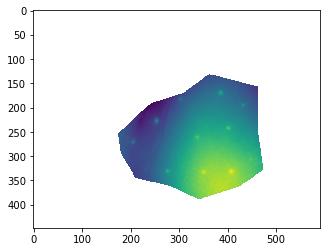

In [10]:
boundary_shapefile = 'data/training_boundary_utm.shp'
# let's build a helper function to read this in - below we'll see that this package will handle all of this internally,
# but it's conventient here for visualization
def convert_shp_to_mask(shp):
    boundary_ds = fiona.open(shp,'r')
    gt = feature_set.GetGeoTransform()
    gt = [gt[1],gt[2],gt[0],gt[4],gt[5],gt[3]]
    mask = np.zeros(feature.shape)
    for n in range(0,len(boundary_ds)):
       rasterio.features.rasterize([boundary_ds[n]['geometry']],transform=gt,default_value=n+1,out=mask)
    return mask
mask = convert_shp_to_mask(boundary_shapefile)
feature[mask == 0] = np.nan
plt.imshow(feature)

Alright, that looks like a starting ROI - a bit small, but we can scale up later.  Now let's import another shapefile of circled termite mounds.

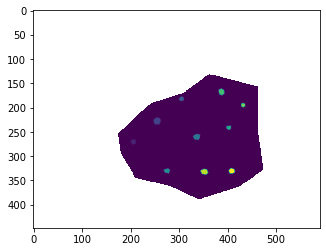

In [11]:
mound_shapefile = 'data/mounds_utm.shp'
def convert_shp_to_mask(shp):
    ds = fiona.open(shp,'r')
    gt = feature_set.GetGeoTransform()
    gt = [gt[1],gt[2],gt[0],gt[4],gt[5],gt[3]]
    mask = np.zeros(feature.shape)
    for n in range(0,len(ds)):
       rasterio.features.rasterize([ds[n]['geometry']],transform=gt,default_value=n+1,out=mask)
    return mask

canvas = np.zeros(mask.shape)
canvas[mask ==0] = np.nan
mounds = convert_shp_to_mask(mound_shapefile)
canvas[mounds !=0 ] = mounds[mounds != 0]
plt.imshow(canvas)

Great - we're ready to go now.  We have a region of interest (albeit a very small one), a feature layer, and a shapefile of identified responses.  We can also critically say that any area in our ROI that is not a labeled termite mound is a 'not termite mound'.  In other words, we have two distinct classes.  Next up, we'll see how we can use these inputs with the CNN training data preparation code.

## Data Prep - Assembling Training Data
Now we'll use the built in package function to assemble some training data.

In [12]:
import build_training_data

window_radius = 32
samples_per_response_per_site = 100
response_file_list = ['data/mounds_utm.shp']
feature_file_list = ['data/landscape7_dem_subset.tif']
                     
features,responses,fold_assignments = build_training_data.build_semantic_segmentation_training_data(
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
                                      boundary_file_list=['data/training_boundary_utm.shp'],
                                      boundary_file_vector_flag=True,
                                      ignore_projections=ignore_projections,
                                      response_vector_flag=True)
print(features.shape)
print(responses.shape)
print(fold_assignments.shape)

(200, 64, 64, 1)
(200, 64, 64, 1)
(200,)


Seems like we've got some training data!  Let's plot it up though to make sure everything looks good though.  Both the features and responses np arrays are 4d arrays.  The first dimension is the sample dimension, the second is y, the third is x, and the last is either the feature or response dimension.  In this case, we only have a 1d feature (the DEM), and the response is always 1d at this stage with each different class being assigned a different integer.  Here are some plots to drive this home:

Text(0.5, 1.0, 'Sample 0 Response')

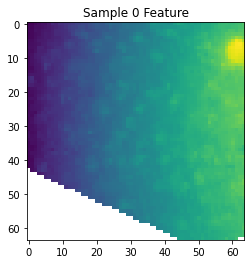

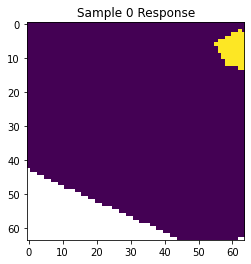

In [13]:
to_plot = features[0,:,:,0]
to_plot[to_plot == -9999] = np.nan
plt.imshow(to_plot)
plt.title('Sample 0 Feature')

plt.figure()
to_plot = responses[0,:,:,0]
to_plot[to_plot == -9999] = np.nan
plt.imshow(responses[0,:,:,0])
plt.title('Sample 0 Response')

That's pretty messy though, so to make life easier we can import plot_utility and use it to plot a bunch of instances.

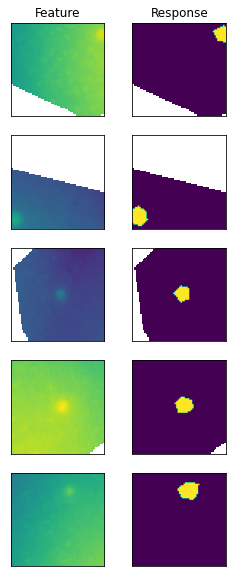

In [14]:
import plot_utility
plot_utility.plot_training_data(features,responses,images_to_plot=5)

Those termite mounds are pretty hard to see, but we didn't use any scaling when we built our training data - what do things look like if we mean center the data?

(200, 64, 64, 1)


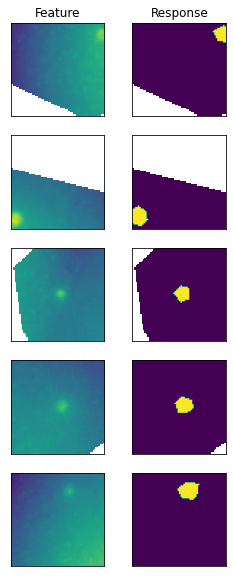

In [15]:
features,responses,fold_assignments = build_training_data.build_semantic_segmentation_training_data(\
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
                                      boundary_file_list=['data/training_boundary_utm.shp'],
                                      boundary_file_vector_flag=True,
                                      response_vector_flag=True,
                                      ignore_projections=ignore_projections,
                                      local_scale_flag='mean')
print(features.shape)
plot_utility.plot_training_data(features,responses,images_to_plot=5)

That's a bit sharper - what happens if we make are window_radius larger?

(200, 128, 128, 1)


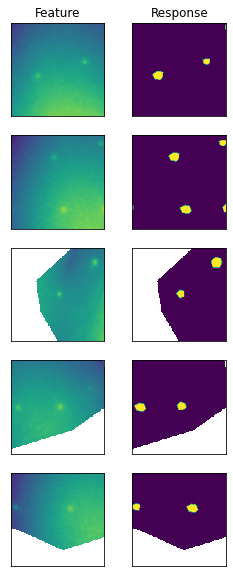

In [16]:
window_radius = 64
features,responses,fold_assignments = build_training_data.build_semantic_segmentation_training_data(\
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
                                      boundary_file_list=['data/training_boundary_utm.shp'],
                                      boundary_file_vector_flag=True,
                                      response_vector_flag=True,
                                      ignore_projections=ignore_projections,
                                      local_scale_flag='mean')
print(features.shape)
plot_utility.plot_training_data(features,responses,images_to_plot=5)

Well, we can definitely see multiple termite mounds, which could be advantageous to the algorithm (more context, after all), but because our ROI is so small, everything is dominated by nodata.  If we sepcify a nodata_maximum_fraction lower than the 0.5 default, can that help?

(200, 128, 128, 1)


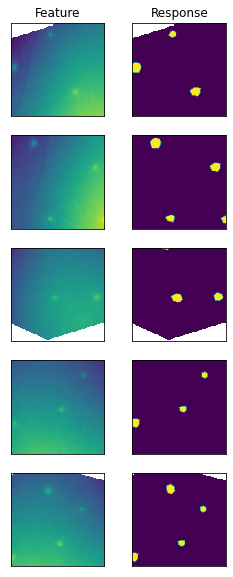

In [17]:
features,responses,fold_assignments = build_training_data.build_semantic_segmentation_training_data(\
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
                                      boundary_file_list=['data/training_boundary_utm.shp'],
                                      boundary_file_vector_flag=True,
                                      response_vector_flag=True,
                                      local_scale_flag='mean',
                                      ignore_projections=ignore_projections,
                                      nodata_maximum_fraction=0.1)
print(features.shape)
plot_utility.plot_training_data(features,responses,images_to_plot=5)

Well, that solved the problem at hand, but it also dropped us down from 33 to 12 samples.  In a real dataset, the ROI boundary would hopefully be bigger, and we'd have more to go on, but sample limitations are very real, so we'll use this as an example to demonstrate how to increase the number of training samples using **center_random_offset_fraction** to randomly move each instance to the side a bit, coupled with **responses_repeats** integer to samle from each response center multiple times.

(800, 128, 128, 1)


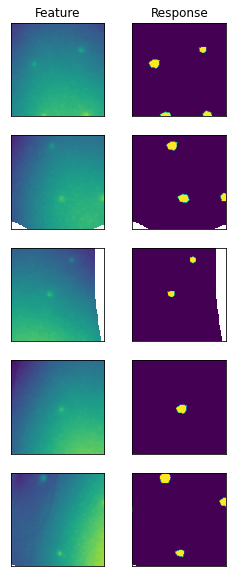

In [18]:
features,responses,fold_assignments = build_training_data.build_semantic_segmentation_training_data(\
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
                                      boundary_file_list=['data/training_boundary_utm.shp'],
                                      boundary_file_vector_flag=True,
                                      response_vector_flag=True,
                                      local_scale_flag='mean',
                                      nodata_maximum_fraction=0.1,
                                      center_random_offset_fraction=0.2,
                                      ignore_projections=ignore_projections,
                                      response_repeats=4)
print(features.shape)
plot_utility.plot_training_data(features,responses,images_to_plot=5)

Nice, that gave us quite a few more samples.  Notice that because of the random offsets, and the nodata_maximum_fraction, the number of samples does not grow linearly (though with larger areas, it will be more linear). 

## 2. Model Training
With training data in hand, it's time to construct a model.  A good, generic model is the 'flex_unet', which follows the general U-Net style (https://arxiv.org/abs/1505.04597), but here we set it up for variable input training data sizes and different numbers of features.  After training any given model, you can also load it back up using the **load_trained_model** function.  For this tutorial, we're just going to load in the pre-trained models, but the code to actually do the training is available as well.  Just set the use_pretrained_model flag below to False - it may just take a few minutes to execute, depending on which machine you're using.

In [19]:
use_pretrained_model = False

In [20]:
import train_model

if use_pretrained_model:
    model = train_model.load_trained_model('termite_flex_unet',window_radius,verbose=False)
else:
    model = train_model.train_semantic_segmentation(features,
                                            responses,
                                            fold_assignments,
                                            'termite_flex_unet',
                                            network_name='flex_unet',
                                            verification_fold=0,
                                            batch_size=10,
                                            network_kwargs={'conv_depth':16})

                                       

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/scratch/genomics/triznam/ecoCNN/network.py:143: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = keras.models.Model(input = inlayer , output=output_layer)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device


Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 12s 26ms/step - loss: 0.2546 - val_loss: 0.1182
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 21ms/step - loss: 0.0914 - val_loss: 0.0773
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 11s 22ms/step - loss: 0.0619 - val_loss: 0.0518
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 21ms/step - loss: 0.0353 - val_loss: 0.0268
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 22ms/step - loss: 0.0236 - val_loss: 0.0225
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [=============

### 3. Model Application
Great - that looks like it worked reasonably well....as least we have low training and verificaiton error rates.  But the real test is in model application.  Let's go ahead and apply the model over the same canvas area.

(-0.5, 969.5, 246.5, -0.5)

<Figure size 432x288 with 0 Axes>

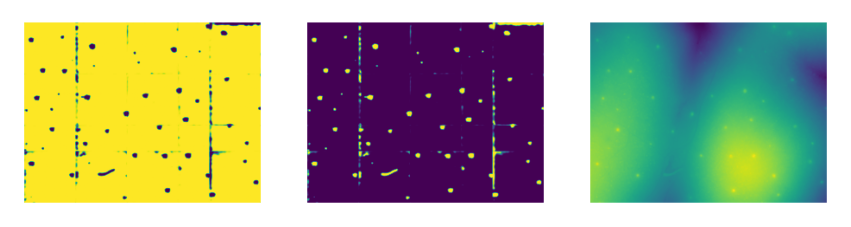

In [21]:
import apply_model
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg

output_folder='output'
apply_model.apply_semantic_segmentation(feature_file_list,
                                        output_folder,
                                        model,
                                        window_radius,
                                        make_tif=True,
                                        make_png=True,
                                        local_scale_flag='mean')
## Apply to images writes a png to an output file - so let's load it back into this notebook
plt.figure(figsize=(15,10))
plt.imshow(mpimg.imread('output/landscape7_dem_subset__prediction.png'))
plt.axis('off')

Here we see 3 images side by side....the first two are the two different class proabilities (not termite mound and termite mound respectively), while the far right is the feature set.  It can be helpful to condense down the output probabilities into a simple classification.  This can be done either by taking the maximum likelihood of the predicted probabilities (on a per-pixel basis), or you can do it by selecting a band-specific threshold.  First, let's check out the maximum likelihood option using the function maximum_likelihood_classification:

(-0.5, 968.5, 359.5, -0.5)

<Figure size 432x288 with 0 Axes>

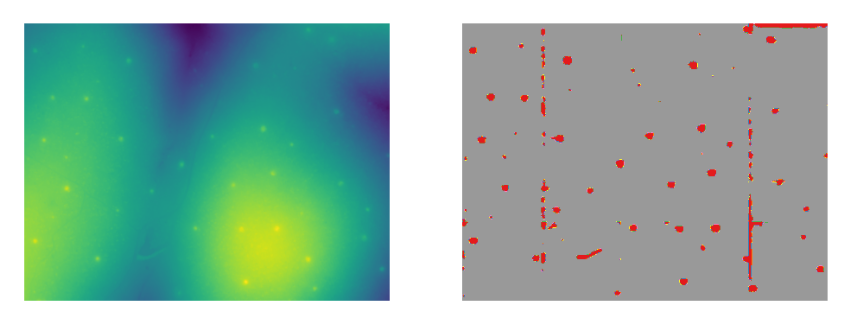

In [22]:
import apply_model
apply_model.maximum_likelihood_classification(feature_file_list,output_folder,feature_band_to_plot=0)
## Apply to images writes a png to an output file - so let's load it back into this notebook
plt.figure(figsize=(15,10))
plt.imshow(mpimg.imread('output/landscape7_dem_subset_classified_max_likelihood_prediction.png'))
plt.axis('off')

Okay, there we go - we have class 0 (no termite mounds) in grey, and class 1 (termite mounds) in red.  This isn't looking to great yet, but before we improve the model, let's see if we can just clean it up with some simple thresholding.

(-0.5, 968.5, 359.5, -0.5)

<Figure size 432x288 with 0 Axes>

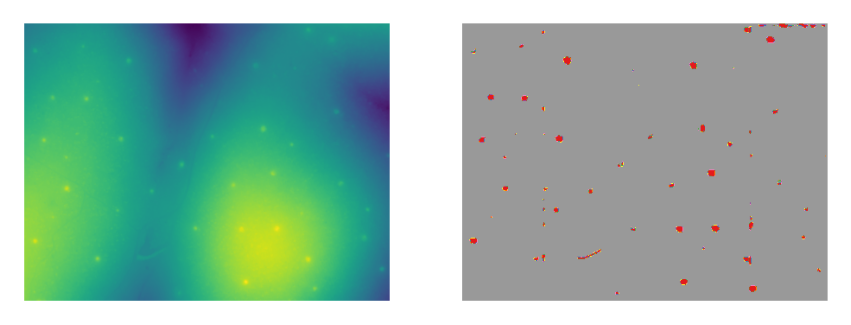

In [23]:
apply_model.convert_probabilities_to_classes(feature_file_list,
                                             output_folder,
                                             response_thresholds=['background',0.999],
                                             response_order=[0,1],
                                             feature_band_to_plot=0)
## Apply to images writes a png to an output file - so let's load it back into this notebook
plt.figure(figsize=(15,10))
plt.imshow(mpimg.imread('output/landscape7_dem_subset_classified_threshold_prediction.png'))
plt.axis('off')

## 4. Model Improvement
While the above is a decent start, it's pretty clear that there are still some issues.  These probably can't all be resolved wihtout a larger training set, but we can certaintly make some progress.  Most blatantly, there are lines running through the image that shouldn't be there (especially obvious in the maximum likelihood version.  As we discussed in the Supplementary Information Walkthrough, using an internal image radius to only consider the interior of any given image during training is advised - after all, if context is really important, than it's unfair to tell the model to predict the edges of an image, where it lacks significant context.  Okay, so what does that look like?

Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 12s 25ms/step - loss: 0.2799 - val_loss: 0.2014
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 11s 22ms/step - loss: 0.1175 - val_loss: 0.0787
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 11s 22ms/step - loss: 0.0536 - val_loss: 0.0362
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 21ms/step - loss: 0.0268 - val_loss: 0.0225
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 21ms/step - loss: 0.0219 - val_loss: 0.0201
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 21ms/step - loss: 0.0173 - val_loss: 0.0196
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 21ms/step - los

(-0.5, 968.5, 359.5, -0.5)

<Figure size 432x288 with 0 Axes>

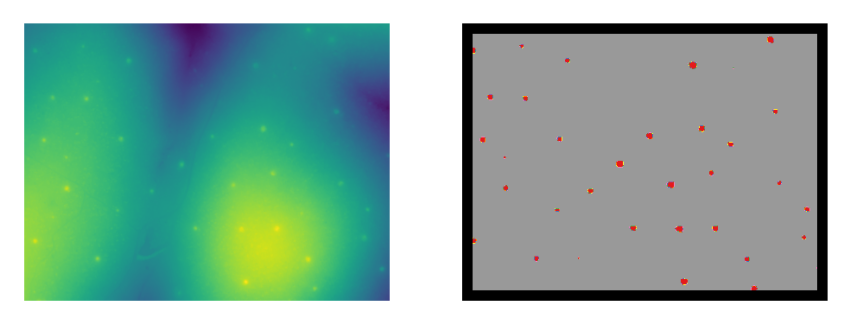

In [24]:
# define an internal window size radius
internal_window_radius = int(round(window_radius*0.75))

# rebuild the training data where we make sure that the response of interest is in that internal window
features,responses,fold_assignments = build_training_data.build_semantic_segmentation_training_data(\
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
                                      internal_window_radius=internal_window_radius,
                                      boundary_file_list=['data/training_boundary_utm.shp'],
                                      boundary_file_vector_flag=True,
                                      response_vector_flag=True,
                                      local_scale_flag='mean',
                                      nodata_maximum_fraction=0.1,
                                      center_random_offset_fraction=0.2,
                                      ignore_projections=ignore_projections,
                                      response_repeats=4)
# train the model where we only penalize the internal portion of the image in the loss function
# or, for the sake for rapid training, just reload a pre-trained model
if use_pretrained_model:
    model = train_model.load_trained_model('termite_flex_unet_internal_window',window_radius,verbose=False)
else:
    model = train_model.train_semantic_segmentation(features,
                                            responses,
                                            fold_assignments,
                                            'termite_flex_unet_internal_window',
                                            internal_window_radius=internal_window_radius,
                                            network_name='flex_unet',
                                            verification_fold=0,
                                            batch_size=10,
                                            network_kwargs={'conv_depth':16})


# now reapply, making sure to slide based on that same internal window radius
apply_model.apply_semantic_segmentation(feature_file_list,
                                        output_folder,
                                        model,
                                        window_radius,
                                        internal_window_radius=internal_window_radius,
                                        make_tif=True,
                                        make_png=True,
                                        local_scale_flag='mean')

apply_model.convert_probabilities_to_classes(feature_file_list,
                                             output_folder,
                                             response_thresholds=['background',0.999],
                                             response_order=[0,1],
                                             feature_band_to_plot=0)
## Apply to images writes a png to an output file - so let's load it back into this notebook
plt.figure(figsize=(15,10))
plt.imshow(mpimg.imread('output/landscape7_dem_subset_classified_threshold_prediction.png'))
plt.axis('off')


Now we're getting somewhere.  Those lines have dissappeared, though the resolved termite mound shape is often not great.  Also, the long topgraphic features in the lower middle-left of the iamge seems to be misidentified as a termite mound.  Maybe weighting, where we class-balance the per-pixel influence on the model, can help.

Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 12s 25ms/step - loss: 1.2595 - val_loss: 1.0980
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 11s 22ms/step - loss: 1.0307 - val_loss: 0.9273
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 22ms/step - loss: 0.5771 - val_loss: 0.2932
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 22ms/step - loss: 0.1461 - val_loss: 0.0942
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 21ms/step - loss: 0.0756 - val_loss: 0.0647
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 22ms/step - loss: 0.0588 - val_loss: 0.0509
Train on 480 samples, validate on 320 samples
Epoch 1/1
480/480 [==============================] - 10s 22ms/step - los

(-0.5, 968.5, 359.5, -0.5)

<Figure size 432x288 with 0 Axes>

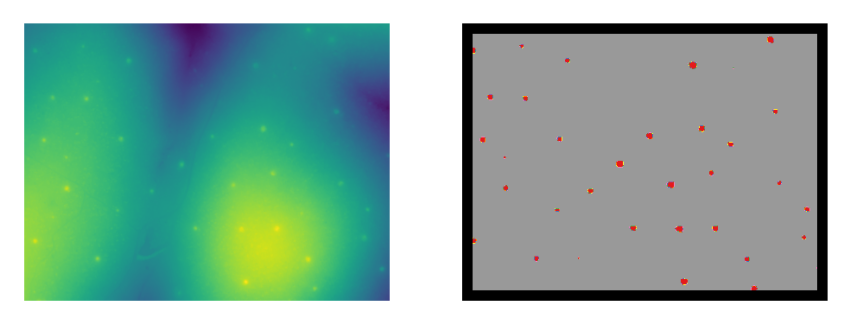

In [25]:

if use_pretrained_model:
    model = train_model.load_trained_model('termite_flex_unet_internal_window_weighted',window_radius,weighted=True,verbose=False)
else:
    train_model.train_semantic_segmentation(features,
                                            responses,
                                            fold_assignments,
                                            'termite_flex_unet_internal_window_weighted',
                                            internal_window_radius=internal_window_radius,
                                            network_name='flex_unet',
                                            verification_fold=0,
                                            batch_size=10,
                                            weighted=True,
                                            network_kwargs={'conv_depth':16})

#now reapply, making sure to slide based on that same internal window radius
apply_model.apply_semantic_segmentation(feature_file_list,
                                        output_folder,
                                        model,
                                        window_radius,
                                        internal_window_radius=internal_window_radius,
                                        make_tif=True,
                                        make_png=True,
                                        local_scale_flag='mean')

apply_model.convert_probabilities_to_classes(feature_file_list,
                                             output_folder,
                                             response_thresholds=['background',0.999],
                                             response_order=[0,1],
                                             feature_band_to_plot=0)
## Apply to images writes a png to an output file - so let's load it back into this notebook
plt.figure(figsize=(15,10))
plt.imshow(mpimg.imread('output/landscape7_dem_subset_classified_threshold_prediction.png'))
plt.axis('off')

That seems to help in some places, and not in all - termite mounds definitely seem more pronounced, and the topographic artifiact in the lower center-left is mostly fixed, though not perfect.  We could continue iterating, but in all likelihood it would be best to just add some training data from a few addtional areas. 

# Conclusion
There are obviously many more combinations that can be explored, depending on the particular use.  We encourage readers to continue through the code files and to read the function documentation for more info.

In [26]:
%watermark -nt

Wed Mar 18 2020 17:27:03


In [27]:
%watermark  -iv -h


fiona      1.8.13
rasterio   1.1.3
keras      2.3.1
numpy      1.18.1
osgeo.gdal 3.0.4
tensorflow 1.15.0
host name: compute-64-15
